## import statements

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import xml.etree.ElementTree as ET
from detector import deploy_func

## function to draw rectangle on image

In [2]:
id_to_name = {}
name_to_id = {}
with open("one-phase/darknet/damage.names","r") as f:
    for i,cname in enumerate(f.readlines()):
        id_to_name[i] = cname.strip()
        name_to_id[cname.strip()] = i
        
COLORS = np.random.uniform(0, 255, size=(len(id_to_name), 3))

In [3]:
# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x1, y1, x2, y2, color):
    global id_to_name
    label = str(id_to_name[class_id])
    cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
    cv2.putText(img, label, (x1-10,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

## get ground truth boxes

In [4]:
def get_ground_truth_boxes(xml_file):
    bbox_list = []
    tree = ET.parse(xml_file)
    root = tree.getroot()

    #loop over each object tag in annotation tag
    for objects in root.findall('object'):
        surfaceType = objects.find('name').text
        bndbox = objects.find('bndbox')
        [minX,minY,maxX,maxY] = [int(child.text) for child in bndbox]
        bbox_list.append([surfaceType, minX, minY, maxX, maxY])
    return bbox_list

## get predictions

In [5]:
input_file = "test.txt"
approach = "one-phase"
yolo_weight = 45000
caffe_weight = 80000
thresh = 0.01
nms = 0.45
scaled = 0
cpu = False
pred_dict = deploy_func(input_file, approach, yolo_weight, caffe_weight, thresh, nms, scaled, cpu)

total images predicted: 6


## display

<Figure size 432x288 with 0 Axes>

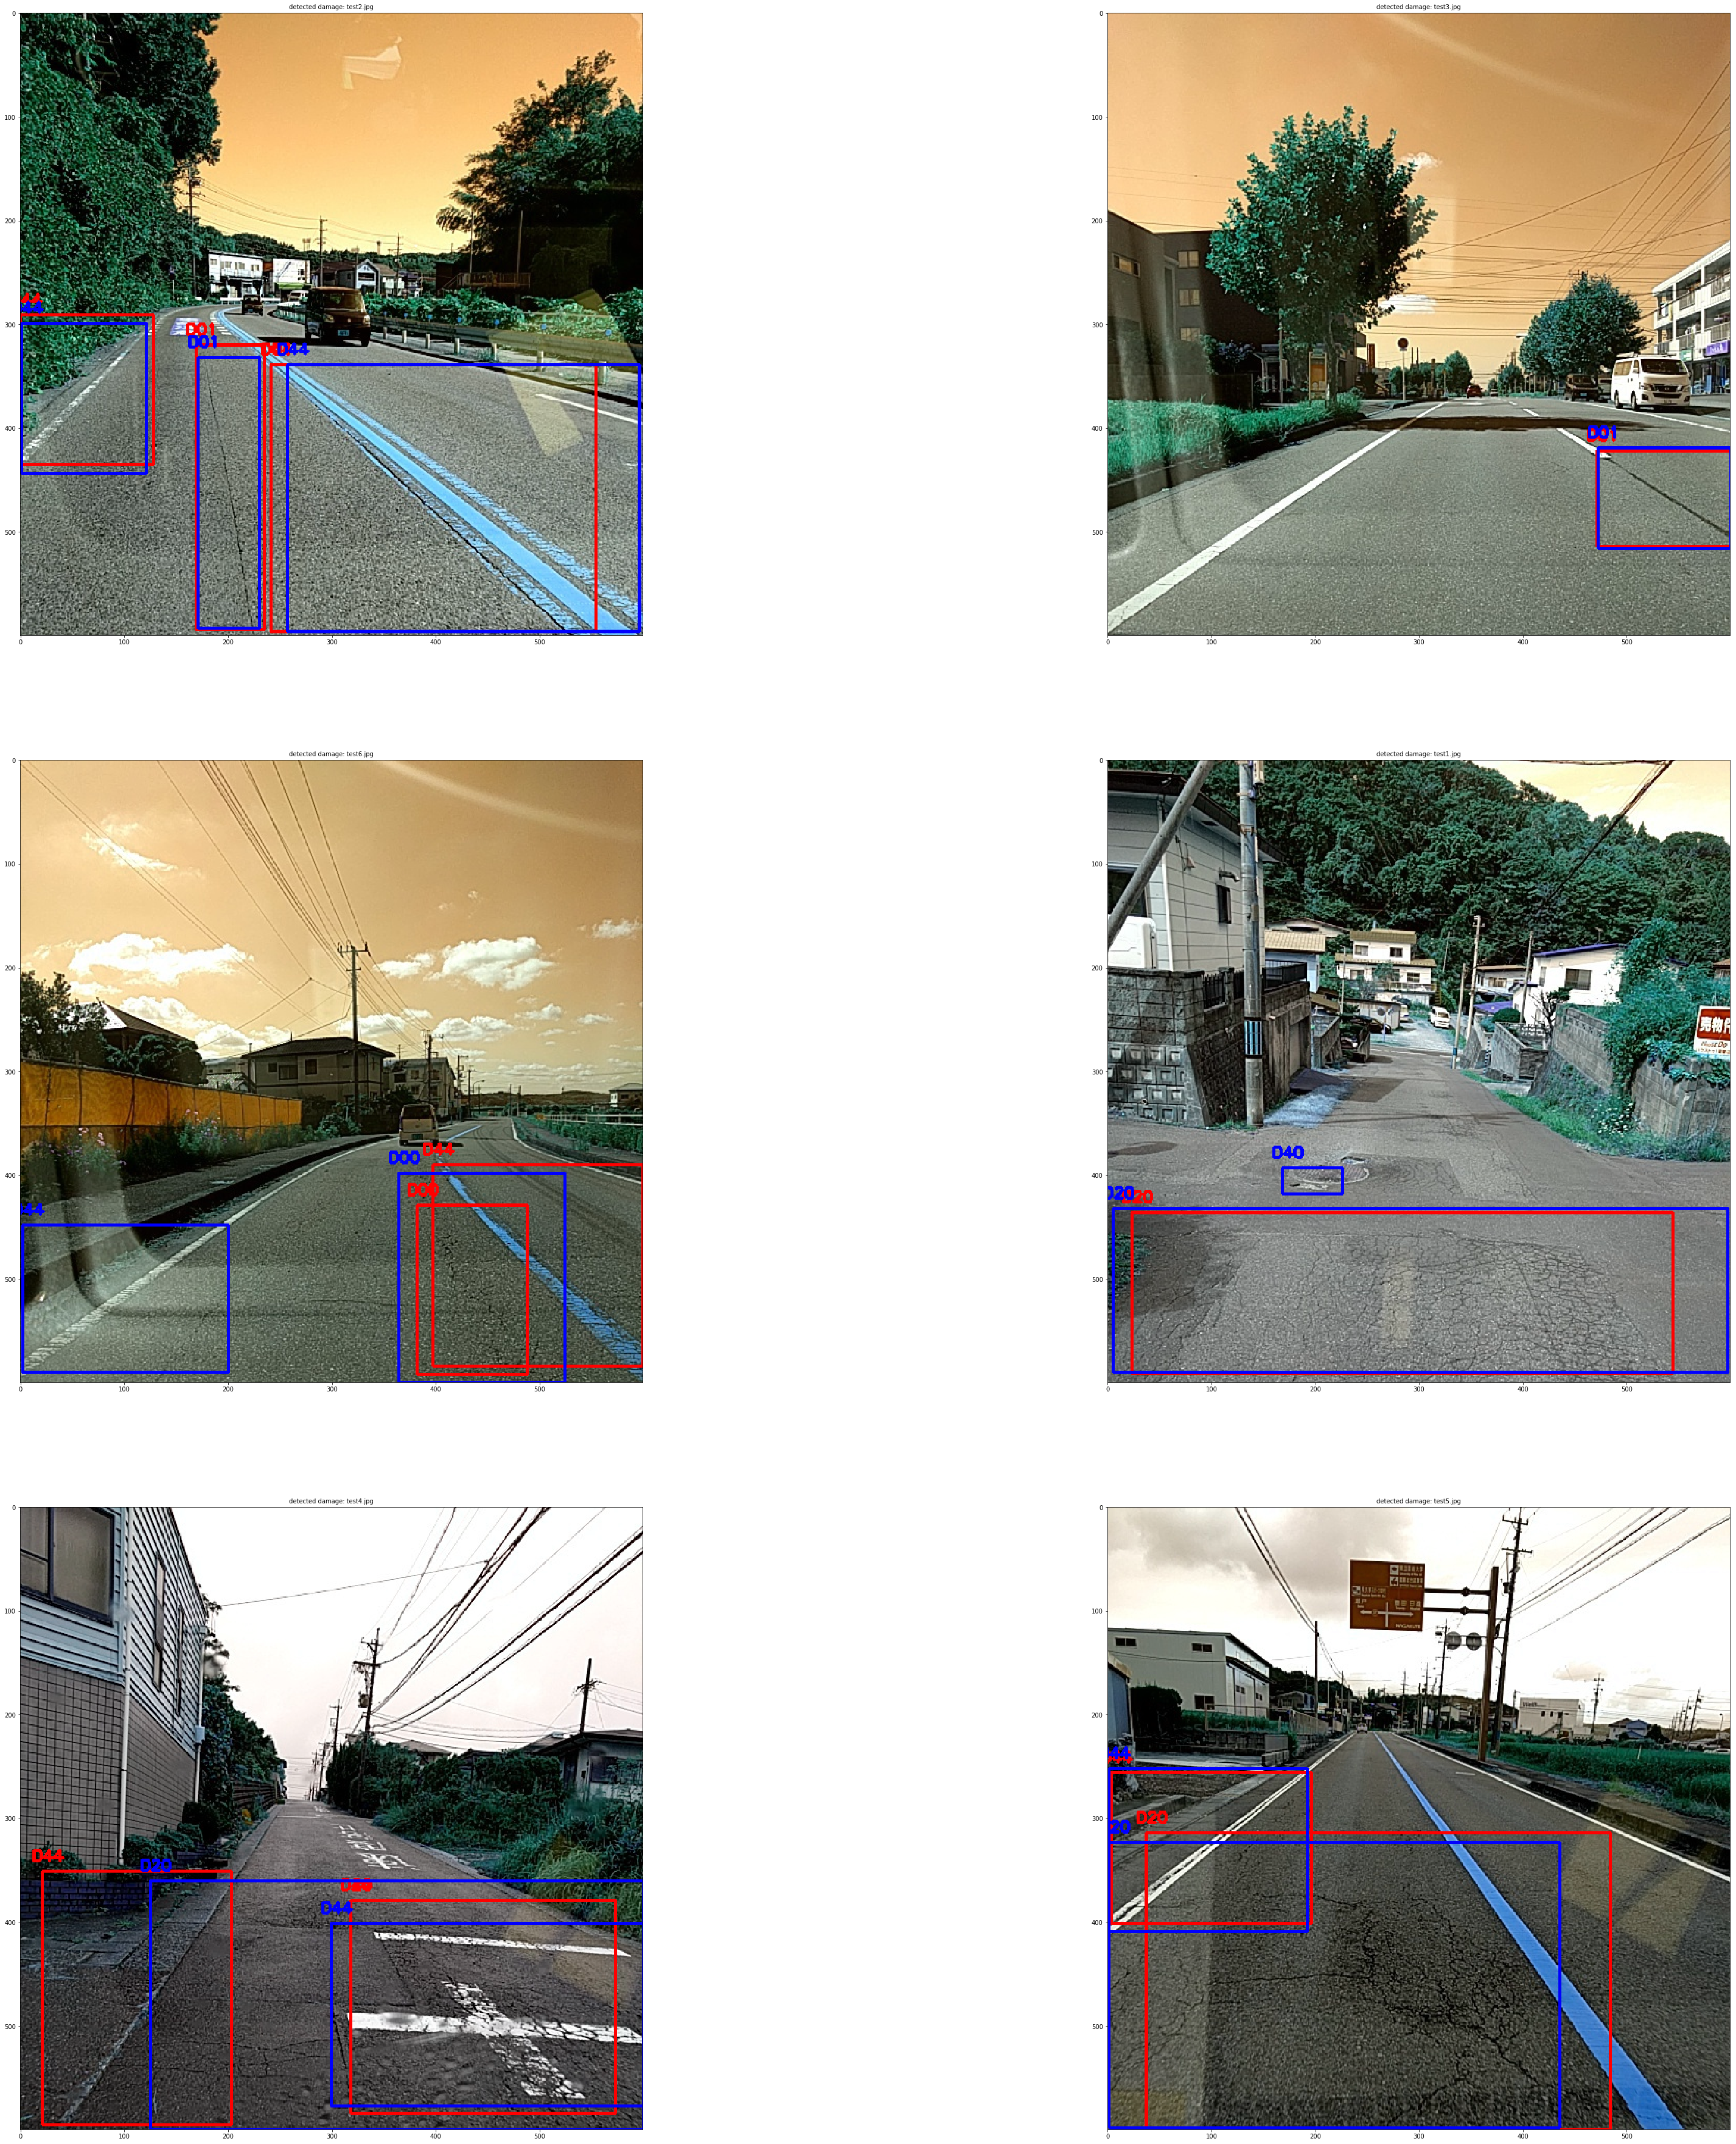

In [6]:
plt.figure(1)
fig, axs = plt.subplots(int(len(pred_dict)/2),2,figsize=(64,64))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
i=0

for img in pred_dict:
    image = cv2.imread(img)
    xml_file = img.replace("JPEGImages","Annotations").replace(".jpg",".xml")
    gt_list = get_ground_truth_boxes(xml_file)
    
    for bbox in pred_dict[img]:
        class_id = int(bbox[1])-1
        color = [255, 0, 0]
        x1, y1, x2, y2 = int(bbox[3]), int(bbox[4]), int(bbox[5]), int(bbox[6])
        draw_bounding_box(image, class_id, bbox[2], x1, y1, x2, y2, color)
            
    for bbox in gt_list:
        class_id = name_to_id[bbox[0]]
        color = [0, 0, 255]
        x1, y1, x2, y2 = int(bbox[1]), int(bbox[2]), int(bbox[3]), int(bbox[4])
        draw_bounding_box(image, class_id, 1.0, x1, y1, x2, y2, color)
    
    output_file = os.path.join("output","images",img.rsplit('.',1)[0]+"_detection.jpg")
    cv2.imwrite(output_file, image)
    
    axs[i].set_title('detected damage: {}'.format(os.path.basename(img)), fontsize=10)
    axs[i].imshow(image)
    i += 1 